In [2]:
from keras.datasets import mnist
import numpy as np
from scipy.spatial.distance import cdist
import random
from sklearn import svm
from scipy.spatial import distance
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from conv import ConvOCDTD
import utils

In [3]:
'''# preporcess for MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1,784)
x_test = x_test.reshape(-1,784)
x_train = x_train/255.
x_test = x_test/255.

index_train = [np.where(y_train==i) for i in range(10)]
index_test = [np.where(y_test==i) for i in range(10)]

# choose digit "2" as inliers, other digits are outliers 
train_inlier = x_train[index_train[2][0]]
train_outlier = x_train[np.where(y_train!=2)]

test_inlier = x_test[index_test[2][0]]
test_outlier = x_test[np.where(y_test!=2)]

# choose part of training sample to find optimal gamma value
toy_data = np.concatenate([x_train[index_train[i][0]][:600] for i in range(10)])
D_new_matrix = cdist(toy_data,toy_data)

#find best gamma and nu value for the OC-SVM model 
best_gamma = utils.find_gamma(D_new_matrix) #0.0037018690558462057
best_nu = utils.find_nu(train_inlier, test_inlier, test_outlier,best_gamma) #1.2648552168552958'''

'# preporcess for MNIST\n(x_train, y_train), (x_test, y_test) = mnist.load_data()\n\nx_train = x_train.reshape(-1,784)\nx_test = x_test.reshape(-1,784)\nx_train = x_train/255.\nx_test = x_test/255.\n\nindex_train = [np.where(y_train==i) for i in range(10)]\nindex_test = [np.where(y_test==i) for i in range(10)]\n\n# choose digit "2" as inliers, other digits are outliers \ntrain_inlier = x_train[index_train[2][0]]\ntrain_outlier = x_train[np.where(y_train!=2)]\n\ntest_inlier = x_test[index_test[2][0]]\ntest_outlier = x_test[np.where(y_test!=2)]\n\n# choose part of training sample to find optimal gamma value\ntoy_data = np.concatenate([x_train[index_train[i][0]][:600] for i in range(10)])\nD_new_matrix = cdist(toy_data,toy_data)\n\n#find best gamma and nu value for the OC-SVM model \nbest_gamma = utils.find_gamma(D_new_matrix) #0.0037018690558462057\nbest_nu = utils.find_nu(train_inlier, test_inlier, test_outlier,best_gamma) #1.2648552168552958'

In [6]:
pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116949 sha256=983425ac80479b2b75b9b0babce115d0ee1a379e15ba389fd4e8bf11ca2383cd
  Stored in directory: /root/.cache/pip/wheels/5b/eb/43/7295e71293b218ddfd627f935229bf54af9018add7fbb5aac6
Successfully built fire


In [7]:
import medmnist
from medmnist import INFO, Evaluator
import torchvision.transforms as transforms

import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms


data_flag = 'pathmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz


In [8]:
train_inlier = []
train_outlier = []

for data,target in train_dataset:
    if target == 7:
      train_inlier.append(data.numpy().reshape(-1))
    elif target == 6:
      train_outlier.append(data.numpy().reshape(-1))


test_inlier = []
test_outlier = []

for data,target in test_dataset:
    if target == 7:
      test_inlier.append(data.numpy().reshape(-1))
    elif target == 6:
      test_outlier.append(data.numpy().reshape(-1))



In [9]:
train_inlier = np.array(train_inlier)/2+0.5
train_outlier = np.array(train_outlier)/2+0.5

test_inlier = np.array(test_inlier)/2+0.5
test_outlier = np.array(test_outlier)/2+0.5

train_inlier = train_inlier.reshape(-1,784,3).mean(axis=-1)
train_outlier = train_outlier.reshape(-1,784,3).mean(axis=-1)

test_inlier = test_inlier.reshape(-1,784,3).mean(axis=-1)
test_outlier = test_outlier.reshape(-1,784,3).mean(axis=-1)

toy_data = np.concatenate([train_inlier[:600],train_outlier[:600]],axis = 0)
D_new_matrix = cdist(toy_data,toy_data)

best_gamma = 6.866488450042998
best_nu =0.0037018690558462057

#best_gamma = utils.find_gamma(D_new_matrix)
#best_nu = find_nu(train_inlier, test_inlier, test_outlier,best_gamma)

In [10]:
print(best_gamma,best_nu)

6.866488450042998 0.0037018690558462057


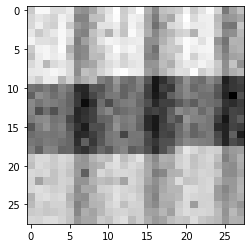

In [11]:
plt.imshow(train_inlier[100].reshape(28,28),cmap='gray')

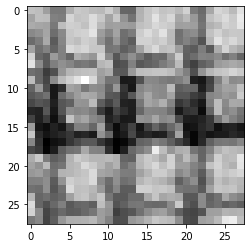

In [12]:
plt.imshow(train_outlier[100].reshape(28,28),cmap='gray')

In [13]:
np.random.seed(123)
np.random.shuffle(test_outlier)
test_outlier =test_outlier[:len(test_inlier)]

In [14]:
random.seed(66)
index1  = random.sample(range(len(train_inlier)),int(len(train_inlier/2)))
random.seed(123)
index2  = random.sample(range(len(train_inlier)),int(len(train_inlier/2)))

train_inlier1 = train_inlier[index1]
train_inlier2 = train_inlier[index2]

#build one-class SVM
clf1 = svm.OneClassSVM(nu=best_nu, kernel="rbf",gamma=best_gamma)
clf2 = svm.OneClassSVM(nu=best_nu, kernel="rbf",gamma=best_gamma)

In [15]:
# extract svm1
clf1.fit(train_inlier1)
dual_coef1 = clf1.dual_coef_.reshape(clf1.dual_coef_.shape[1],)
dual_sort1 = np.argsort(-dual_coef1)
m = 100
dual1 = dual_coef1[dual_sort1][:m]
support_vectors1 = clf1.support_vectors_[dual_sort1[:m],:]

# extract svm2
clf2.fit(train_inlier2)
dual_coef2 = clf2.dual_coef_.reshape(clf2.dual_coef_.shape[1],)
dual_sort2 = np.argsort(-dual_coef2)
n = 100
dual2 = dual_coef2[dual_sort2][:n]
support_vectors2 = clf2.support_vectors_[dual_sort2[:n],:]

In [16]:
def outlierness(X,svm,dual,gamma):
    dim = svm.shape[1]
    X=X.reshape(-1,dim)
    svm=svm.reshape(-1,dim)
    d=distance.cdist(X,svm,'sqeuclidean')
    return -np.log( (dual*np.exp(-gamma*d)).sum(axis=1) )

In [17]:
def get_auc_value(test_inlier,test_outlier,svm, dual, n_svm, gamma):
    dual_temp = dual[:n_svm]
    dual_temp = dual_temp/dual_temp.sum()
    value1 = -outlierness(test_inlier,svm[:n_svm,:],dual_temp,gamma)
    value2 = -outlierness(test_outlier,svm[:n_svm,:],dual_temp,gamma)
    value = np.concatenate((value1,value2),axis=0)
    label = np.concatenate( (np.ones(len(test_inlier)),np.zeros(len(test_outlier)) ),axis=0 )
    auc_value =  roc_auc_score(label,value) 

    return auc_value,value.max(),value.min()

In [18]:
get_auc_value(test_inlier,test_outlier,support_vectors1,dual1,100,best_gamma)

(0.9810314769156121, -17.99347131302437, -222.8350179243081)

In [19]:
get_auc_value(test_inlier,test_outlier,support_vectors2,dual2,100,best_gamma)

(0.9720098622779154, -21.682854909325087, -204.9932504613008)

In [20]:
def get_add_auc_value(test_inlier,test_outlier,svm1,svm2,dual1,dual2,n_svm,gamma):
    temp_sv1= svm1[:n_svm]
    temp_sv2= svm2[:n_svm]
    temp_dual1 = dual1[:n_svm]
    temp_dual2 = dual2[:n_svm]
    temp_dual1 = temp_dual1/temp_dual1.sum()
    temp_dual2 = temp_dual2/temp_dual2.sum()

    value1 = -outlierness(test_inlier,temp_sv1,temp_dual1,gamma)-outlierness(test_inlier,temp_sv2,temp_dual2,gamma)
    value2 = -outlierness(test_outlier,temp_sv1,temp_dual1,gamma)-outlierness(test_outlier,temp_sv2,temp_dual2,gamma)
    value = np.concatenate((value1,value2),axis=0)
    label = np.concatenate( (np.ones(len(test_inlier)),np.zeros(len(test_outlier)) ),axis=0 )
    auc_value =  roc_auc_score(label,value) 
    return auc_value,value.max()/2,value.min()/2

In [21]:
get_add_auc_value(test_inlier,test_outlier,support_vectors1,support_vectors2,dual1,dual2,100,best_gamma)

(0.9782950897365734, -21.367411568877532, -213.91413419280445)

In [22]:
def get_weighted_dual(sv1,sv2,d1,d2,best_gamma=best_gamma,alpha=0.1,normalization=1):
    support_matrix = sv2[np.newaxis,:,:]+sv1[:,np.newaxis,:]
    support_vector = support_matrix.reshape(-1,784)/2
    dual_matrix = np.log(d2)[np.newaxis,:]+np.log(d1)[:,np.newaxis]
    dual_matrix = np.exp(dual_matrix)
    dual = dual_matrix.reshape(-1,)

    dist_matrix = distance.cdist(sv1,sv2,metric="sqeuclidean")
    n = max( int(alpha*len(sv2)),1)

    index = np.argsort(dist_matrix)[:,n:]
    for i in range(len(sv1)):  
      dist_matrix[i][index[i]] = -1

    dist_matrix = dist_matrix.reshape(-1,) 
    support_vector = support_vector[dist_matrix>-0.5]
    dual = dual[dist_matrix>-0.5]

    bias_matrix = np.exp(-dist_matrix*best_gamma*0.5)
    bias = bias_matrix.reshape(-1,)[dist_matrix>-0.5]
    
    dual = dual*bias
    
    if normalization:
      dual = dual/dual.sum()
    return support_vector,dual

In [23]:
def get_times_auc_value(test_inlier,test_outlier,svm1,svm2,dual1,dual2,n_svm):
      temp_sv1= svm1[:n_svm]
      temp_sv2= svm2[:n_svm]
      temp_dual1 = dual1[:n_svm]
      temp_dual2 = dual2[:n_svm]
      temp_dual1 = temp_dual1/temp_dual1.sum()
      temp_dual2 = temp_dual2/temp_dual2.sum()

      sv1,d1 = get_weighted_dual(temp_sv1,temp_sv2,temp_dual1,temp_dual2)
      sv2,d2 = get_weighted_dual(temp_sv2,temp_sv1,temp_dual2,temp_dual1)

      value1 = -outlierness(test_inlier,sv1,d1,best_gamma*2)-outlierness(test_inlier,sv2,d2,best_gamma*2)
      value2 = -outlierness(test_outlier,sv1,d1,best_gamma*2)-outlierness(test_outlier,sv2,d2,best_gamma*2)
      value = np.concatenate((value1,value2),axis=0)
      label = np.concatenate( (np.ones(len(test_inlier)),np.zeros(len(test_outlier)) ),axis=0 )
      auc_value =  roc_auc_score(label,value) 
      return auc_value,value.max()/2,value.min()/2

In [24]:
get_times_auc_value(test_inlier,test_outlier,support_vectors1,support_vectors1,dual1,dual1,100)

(0.9810653291281363, -31.38177897752245, -441.0648686250858)

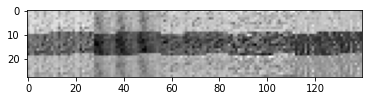

In [25]:
plt.imshow((support_vectors1[0:5,:]).reshape(1,5,28,28).transpose(0,2,1,3).reshape(1*28,5*28),cmap='gray')

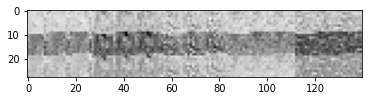

In [26]:
plt.imshow((support_vectors2[0:5,:]).reshape(1,5,28,28).transpose(0,2,1,3).reshape(1*28,5*28),cmap='gray')

In [27]:
class OCSVM():
  def __init__(self,q,sigma,alpha,svs):
    self.q = q
    self.sigma = sigma
    self.alpha = alpha
    self.svs = svs

class Net(nn.Module):
    def __init__(self,ocsvm):
        super(Net, self).__init__()
        self.myconv = ConvOCDTD(ocsvm,1)

    def forward(self,x):
        x = self.myconv(x)
        return x
    def explain(self,x):
        x = self.myconv.explain(x)
        return x

In [28]:
def get_R(support_vectors,dual,best_gamma,test_loader):
  ocsvm = OCSVM(2,np.sqrt(0.5/best_gamma),dual,support_vectors)
  net = Net(ocsvm)
  print(net)
  y_explain_=[]
  for i,x_batch in enumerate(test_loader):
    y_explain = net.explain(x_batch[0])
    y_explain_.append(y_explain)

  R=np.zeros([50,784])
  for i in range(50):
    R[i,:]=(y_explain_[i]).detach().numpy().reshape(-1,784)
    #R[i,:]=-R[i,:]

  return R

In [29]:
def get_mix_R(sv1,sv2,d1,d2,best_gamma,test_loader):
  temp_sv1,temp_d1 = get_weighted_dual(sv1,sv2,d1,d2)
  temp_sv2,temp_d2 = get_weighted_dual(sv2,sv1,d2,d1)

  temp_R1 = get_R(temp_sv1,temp_d1,2*best_gamma,test_loader)
  temp_R2 = get_R(temp_sv2,temp_d2,2*best_gamma,test_loader)

  return temp_R1+temp_R2

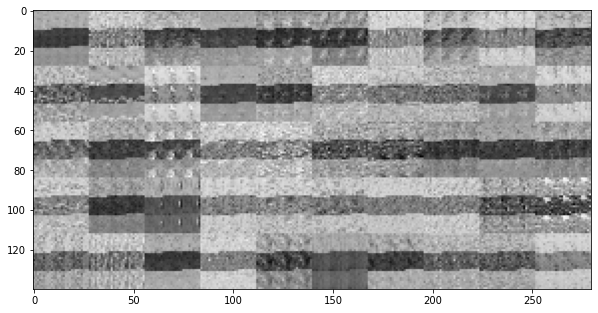

In [30]:
plt.figure(figsize=[10,20])
plt.imshow((test_inlier[:50]).reshape(5,10,28,28).transpose(0,2,1,3).reshape(5*28,10*28),cmap='gray')

In [31]:
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_inlier[:50]).reshape(50,1,28,28))
inlier_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

In [32]:
support_vector_ub1,dual_ub1 = get_weighted_dual(support_vectors1,support_vectors1,
                    dual1,dual1,best_gamma=best_gamma,normalization=1)

support_vector_ub2,dual_ub2 = get_weighted_dual(support_vectors2,support_vectors2,
                    dual2,dual2,best_gamma=best_gamma,normalization=1)

In [33]:
R1_in = get_R(support_vectors1,dual1,best_gamma,inlier_loader)
R2_in = get_R(support_vectors2,dual2,best_gamma,inlier_loader)
R_all_in=(R1_in+R2_in)

R1_ub_in = get_R(support_vector_ub1,dual_ub1,2*best_gamma,inlier_loader)
R2_ub_in = get_R(support_vector_ub2,dual_ub2,2*best_gamma,inlier_loader)
R1xR2_ub_in = get_mix_R(support_vectors1,support_vectors2,dual1,dual2,best_gamma,inlier_loader)

Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)


In [34]:
test_dataset = torch.utils.data.TensorDataset(torch.Tensor(test_outlier[:50]).reshape(50,1,28,28))
outlier_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)

In [35]:
R1_out = get_R(support_vectors1,dual1,best_gamma,outlier_loader)
R2_out = get_R(support_vectors2,dual2,best_gamma,outlier_loader)
R_all_out=(R1_out+R2_out)

R1_ub_out = get_R(support_vector_ub1,dual_ub1,2*best_gamma,outlier_loader)
R2_ub_out = get_R(support_vector_ub2,dual_ub2,2*best_gamma,outlier_loader)
R1xR2_ub_out = get_mix_R(support_vectors1,support_vectors2,dual1,dual2,best_gamma,outlier_loader)

Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 100, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)
Net(
  (myconv): ConvOCDTD(
    (conv): ConvDist(1, 1000, kernel_size=(28, 28), stride=(1, 1))
    (pool): SoftMinMaxPool()
  )
)


In [36]:
def get_img_result(index_in,index_out,R_in,R_out,r=0.0):

    R_result_in = np.concatenate( [R_in[idx].reshape(1,-1) for idx in index_in ] )
    R_result_out = np.concatenate( [R_out[idx].reshape(1,-1) for idx in index_out ] )
    R_result = np.concatenate([R_result_in,R_result_out])
    R_result = (R_result-R_result.min())/(R_result.max()-R_result.min())

    R_result[R_result<r] = 0
    return R_result

In [37]:
index_in = [5,1,3,4]
index_out = [4,45,42,26]

In [38]:
R1_temp = get_img_result(index_in,index_out,R1_in,R2_out)
R2_temp = get_img_result(index_in,index_out,R2_in,R2_out)

R1_ub_temp = get_img_result(index_in,index_out,R1_ub_in,R1_ub_out)
R2_ub_temp = get_img_result(index_in,index_out,R2_ub_in,R2_ub_out)

R_all_temp = get_img_result(index_in,index_out,R_all_in,R_all_out)
R1xR2_ub_temp = get_img_result(index_in,index_out,R1xR2_ub_in,R1xR2_ub_out)

In [39]:
def get_imgdata(index_in,index_out):
    R1 = np.concatenate([test_inlier[idx].reshape(1,-1) for idx in index_in])
    R2 = np.concatenate([test_outlier[idx].reshape(1,-1) for idx in index_out])
    R_result = np.concatenate( [R1,R2] )

    return R_result

In [40]:
R_original = get_imgdata(index_in,index_out)

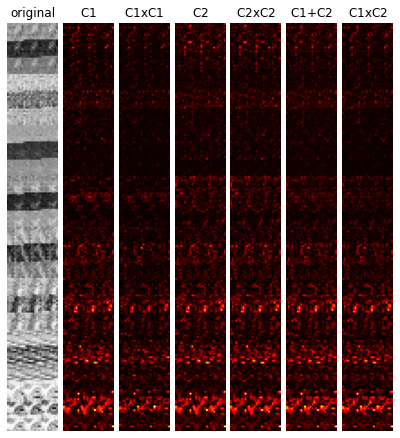

In [41]:
plt.figure(figsize=[7,7.5])

ax1 = plt.subplot(1,7,1)
ax1.set_title("original")
ax1.axis("off")
ax1.imshow(R_original.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='gray')

ax2 = plt.subplot(1,7,2)
ax2.axis("off")
ax2.set_title('C${1}$')
ax2.imshow(R1_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax3 = plt.subplot(1,7,3)
ax3.axis("off")
ax3.set_title('C${1}$xC${1}$')
ax3.imshow(R1_ub_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax4 = plt.subplot(1,7,4)
ax4.axis("off")
ax4.set_title('C${2}$')
ax4.imshow(R2_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax5 = plt.subplot(1,7,5)
ax5.axis("off")
ax5.set_title('C${2}$xC${2}$')
ax5.imshow(R2_ub_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax6 = plt.subplot(1,7,6)
ax6.axis("off")
ax6.set_title('C${1}$+C${2}$')
ax6.imshow(R_all_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)

ax7 = plt.subplot(1,7,7)
ax7.set_title('C${1}$xC${2}$')
ax7.axis("off")
ax7.imshow(R1xR2_ub_temp.reshape(8,1,28,28).transpose(0,2,1,3).reshape(8*28,1*28),cmap='hot',vmax=1,vmin=0)


plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("MNIST.pdf",bbox_inches="tight")